In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import sys
from dataclasses import dataclass # Requires Python version 3.7

In [23]:
# Allow using a GPU or not. cupy will not be imported unless needed.
# The npcp alias will be used to either numpy or cupy based on the configuration to allow using a GPU or not.

globalUseGPU = True
if globalUseGPU:
    import cupy as cp
    npcp = cp
else:
    npcp = np

In [3]:
# Pulling the dataset from a csv so it doesn't have to be downloaded everytime.
# TODO: Change this to download so it will work for other people to run.

fill_df = pd.read_csv("fullMnist.csv", index_col=0)

In [70]:
@dataclass
class modelClass:
    clazz: str
    firstIndex: int
    lastIndex: int

class TimsEfficientLdaClassifier:
    def __init__(self, df: pd.DataFrame):
        self.classes = []
        self.sampleSize: int
        self.classMeans = []
        data = df.sort_values(by=['label'])
        data = data.reset_index(drop=True)
        for clazz in data.label.unique():
            classSubsetIndexes = data.loc[data['label'] == clazz].index
            self.classes.append(modelClass(str(clazz), classSubsetIndexes[0], classSubsetIndexes[-1]))
        self.trainData = data.drop(columns='label').to_numpy()
        if globalUseGPU:
            # Transfer training data to device
            self.trainData = cp.asarray(self.trainData)

        self.trainLabels = data.label.to_numpy()
        self.sampleSize = self.trainData.shape[1]  
        self.numSamples = self.trainData.shape[0]
        
    def buildClassMeans(self):
        for clazz in self.classes:
            self.classMeans.append(npcp.mean(self.trainData[clazz.firstIndex:clazz.lastIndex + 1], axis=0))

    def withinClassCovariance(self):
        withinClassCov = npcp.zeros(shape=(self.sampleSize, self.sampleSize))
        for clazz in  self.classes:
            withinClassCov += self._withinClassCovarianceForClass(clazz)
        self.withinClassCovariance = withinClassCov
    
    def _withinClassCovarianceForClass(self, clazz):
        classCov = npcp.zeros(shape=(self.sampleSize, self.sampleSize))
        classIndex = self.classes.index(clazz)
        for i in range(clazz.firstIndex, clazz.lastIndex + 1):
            currentRow = npcp.subtract(self.trainData[i], self.classMeans[classIndex])
            currentRow = npcp.outer(npcp.transpose(currentRow), currentRow)
            classCov += currentRow
        return classCov

    def betweenClassCovariance(self):
        sbCovariance = npcp.zeros(shape=(self.sampleSize, self.sampleSize))
        globalMean = npcp.sum(self.trainData, axis=0) / self.numSamples
        for clazz in self.classes:
            currentClass = npcp.subtract(self.classMeans[self.classes.index(clazz)], globalMean)
            currentClass = npcp.outer(npcp.transpose(currentClass), currentClass)
            # Scale by the number of samples of this class
            currentClass = currentClass * (clazz.lastIndex + 1 - clazz.firstIndex)
            sbCovariance += currentClass
        self.betweenClassCovariance = sbCovariance

    def getSortedEigens(self):
        weightMatrix = npcp.matmul(npcp.linalg.pinv(self.withinClassCovariance), self.betweenClassCovariance)
        eigenValues, self.eigenVectors = npcp.linalg.eigh(weightMatrix)
        # Transpose the eigenVectors because of the way it returns and the way I am indexing it
        self.eigenVectors = npcp.transpose(self.eigenVectors)        
        # Add index for each eigenvalue so that it can be correllated to its eigenvector after a sort
        eigenValues = npcp.c_[eigenValues, range(0, eigenValues.shape[0])]
        # Sort the eigenValues largest first
        self.sortedEigenValues = npcp.flip(eigenValues[eigenValues[:,0].argsort()], axis=0)
    
    def createMapToLowerDimensionality(self, lowerDimension: int):
        self.lowerDimension = lowerDimension
        self.w = np.zeros(shape=(self.lowerDimension, self.sampleSize), dtype=np.complex128)
        for i in range(0, self.lowerDimension):
            self.w[i] = self.eigenVectors[int(self.sortedEigenValues[i][1].real)]
        self.w = np.transpose(self.w)

    def projectDataToLowerDimension(self):
        self.projectedData = np.matmul(self.trainData, self.w)

     #TODO: re-write
    def gaussian(self):
        # get projected means
        self.projectedMeans = np.zeros(shape=(len(self.classes), self.lowerDimension))
        self.projectedCov = np.zeros(shape=(len(self.classes), self.lowerDimension, self.lowerDimension))
        self.projectedPriors = np.zeros(shape=(len(self.classes), self.lowerDimension))
        for clazz in self.classes:
            indexForClass = self.classes.index(clazz)
            self.projectedMeans[indexForClass], self.projectedCov[indexForClass], self.projectedPriors[indexForClass] = self.guassianForClass(clazz)

    # rewrite?
    def guassianForClass(self, clazz):
        classSubset = self.trainData[clazz.firstIndex:clazz.lastIndex + 1]
        numSamplesForClass = clazz.lastIndex + 1 - clazz.firstIndex
        projectedClassSubset = np.matmul(classSubset, self.w).real
        classSubsetMeans = np.mean(projectedClassSubset, axis=0)
        classSubsetCov = np.cov(projectedClassSubset, rowvar=False)
        classSubsetPriors = numSamplesForClass / self.numSamples
        return classSubsetMeans, classSubsetCov, classSubsetPriors

    # rewrite?
    def score(self, testData, labels):
        projectedData = np.matmul(testData, self.w)
        gaussian_likelihoods = np.zeros(shape=(projectedData.shape[0], len(self.classes)))
        for i, row in enumerate(projectedData):
            res = np.zeros(shape=(len(self.classes)), dtype=np.complex128)
            for clazz in self.classes:
                indexForClass = self.classes.index(clazz)
                res[indexForClass] = (self.projectedPriors[indexForClass] * self.gaussian_distribution( row,
                                        self.projectedMeans[indexForClass], self.projectedCov[indexForClass]))[0]
            gaussian_likelihoods[i] = res
        predictions = np.argmax(gaussian_likelihoods, axis=1)
        return np.sum(predictions == labels) / len(labels), predictions, projectedData

    # rewrite?
    def gaussian_distribution(self, data, mean, cov):
        detCov = np.linalg.det(cov)
        # Avoid divide by zero errors
        if detCov == 0:
            detCov = sys.float_info.min
        # Avoid sqrt negative numbers
        if detCov < 0:
            detCov = detCov * -1
        scalar = (1. / ((2 * np.pi) ** (data.shape[0] / 2.))) * (1/ np.sqrt(detCov))
        diffMean = np.subtract(data, mean)
        return scalar * np.exp(-np.dot(np.dot(diffMean, np.linalg.pinv(cov)), diffMean.T) / 2.)
    
    def transferDataToHost(self):
        # Data needed to be tansfered: training data, eigenvalues, eigenvectors
        self.trainData = cp.asnumpy(self.trainData)
        self.sortedEigenValues = cp.asnumpy(self.sortedEigenValues)
        self.eigenVectors = cp.asnumpy(self.eigenVectors)
        for i in range(0, len(self.classMeans)):
            self.classMeans[i] = cp.asnumpy(self.classMeans[i])
        

    def train(self):
        self.buildClassMeans()
        self.withinClassCovariance()
        self.betweenClassCovariance()
        self.getSortedEigens()
        if globalUseGPU:
            self.transferDataToHost()
        

    def LowerDimensionality(self, lowerDimensions: int):
        self.createMapToLowerDimensionality(lowerDimensions)
        self.projectDataToLowerDimension()
        self.gaussian()
        

In [71]:
# Setup the data to be used
# In the MNIST dataset, the first 60000 samples are training data, and the last 10000 are test data

newClassifier = TimsEfficientLdaClassifier(fill_df.head(60000))
testData = fill_df.tail(10000).drop(columns='label').to_numpy()
testLabels = fill_df.tail(10000).label.to_numpy()

In [72]:
newClassifier.train()


In [83]:
# Calculate the accuracy across many dimensions

dimensions = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
accuracies = []

for d in dimensions:
    newClassifier.LowerDimensionality(d)
    accuracy, predictions, projectedData = newClassifier.score(testData, testLabels)
    accuracies.append(accuracy)


/tmp/ipykernel_16170/241811137.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussian_likelihoods[i] = res


<function matplotlib.pyplot.show(close=None, block=None)>

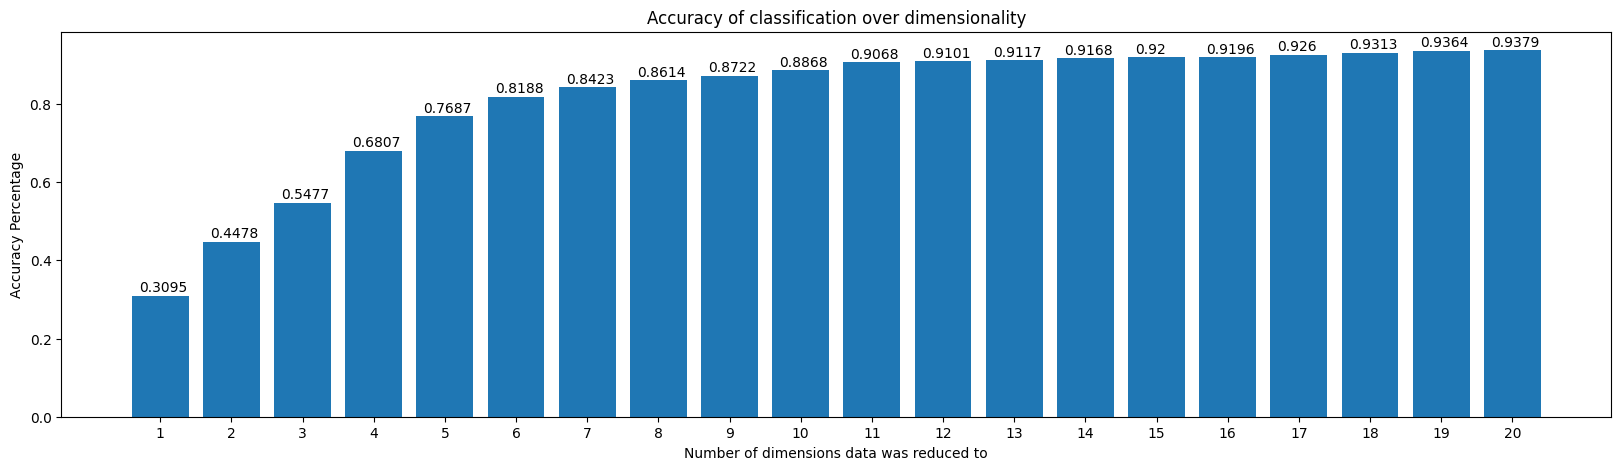

In [95]:
# Draw a bar graph showing how accurate the classification is across dimensions

plt.figure(figsize = (20,5))
plt.xticks(dimensions)

plt.title("Accuracy of classification over dimensionality")
plt.ylabel("Accuracy Percentage")
plt.xlabel("Number of dimensions data was reduced to")

plt.bar(dimensions, accuracies)
for bar in zip(dimensions, accuracies):
    plt.text(bar[0] - 0.3, bar[1] + 0.01, bar[1])
plt.show

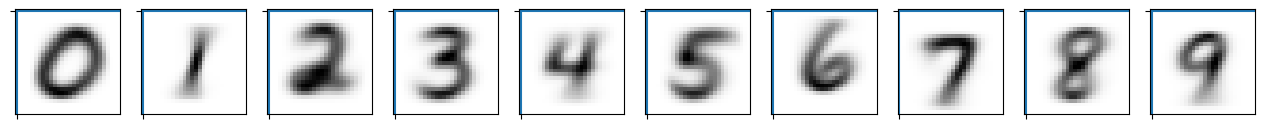

In [75]:
# Draw the means for each class. This gives an idea of what the model will be looking for
count = 0
sample_size = 10
plt.figure(figsize=(16, 6))
for i in range(0, sample_size):
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(newClassifier.classMeans[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [76]:
# Some common code for plotting

# Project the data down to 2 dimensions so it can be plotted
newClassifier.LowerDimensionality(2)
accuracy, predictions, projectedData = newClassifier.score(testData, testLabels)

# Get colors to use for each class
colors = cm.rainbow(np.linspace(0, 1, len(newClassifier.classes)))

# Create a custom legend
customLegendPoints = []
for i,clazz in enumerate(newClassifier.classes):
    customLegendPoints.append(Line2D([0], [0], label = clazz.clazz, marker='.', markersize=10, color=colors[i], linestyle=''))


/tmp/ipykernel_16170/241811137.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussian_likelihoods[i] = res


/home/timmy/mlProject/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


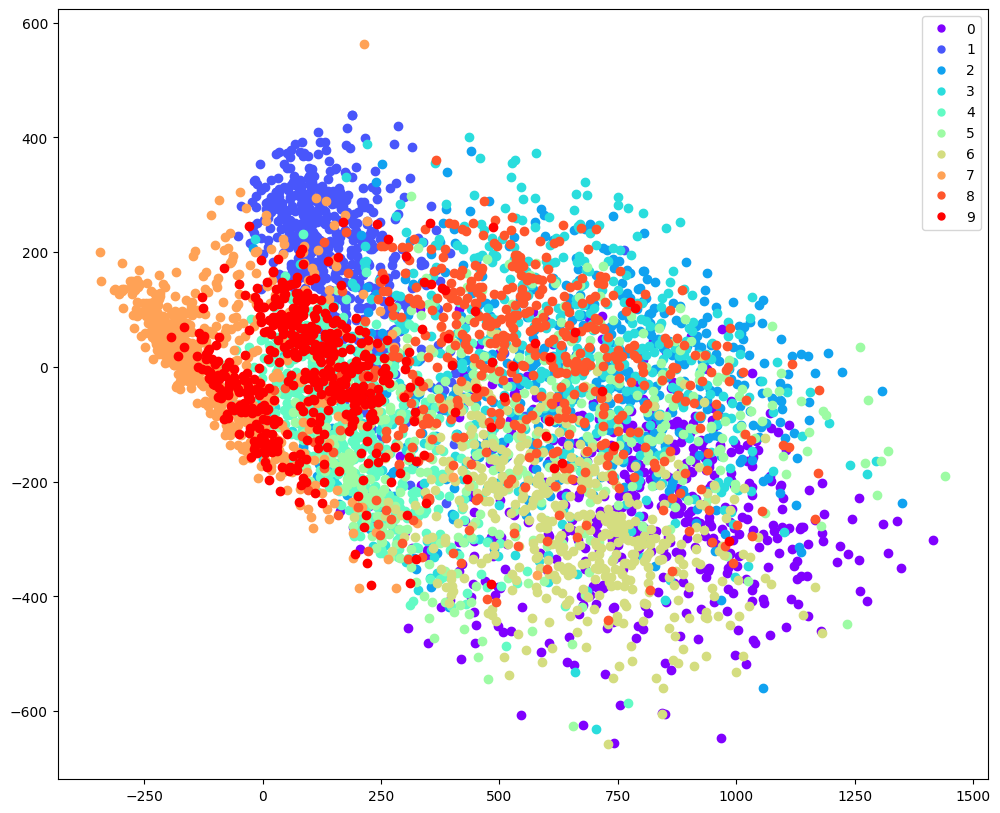

In [77]:
# Plot some of the projected data

plt.figure(figsize=(12,10))
stride = 12
for i, point in enumerate(newClassifier.projectedData[::stride]):
    plt.scatter(point[0], point[1], color=colors[newClassifier.trainLabels[i*stride]])

# Create a custom legend
customLegendPoints = []
for i,clazz in enumerate(newClassifier.classes):
    customLegendPoints.append(Line2D([0], [0], label = clazz.clazz, marker='.', markersize=10, color=colors[i], linestyle=''))

plt.legend(handles=customLegendPoints)
plt.show()

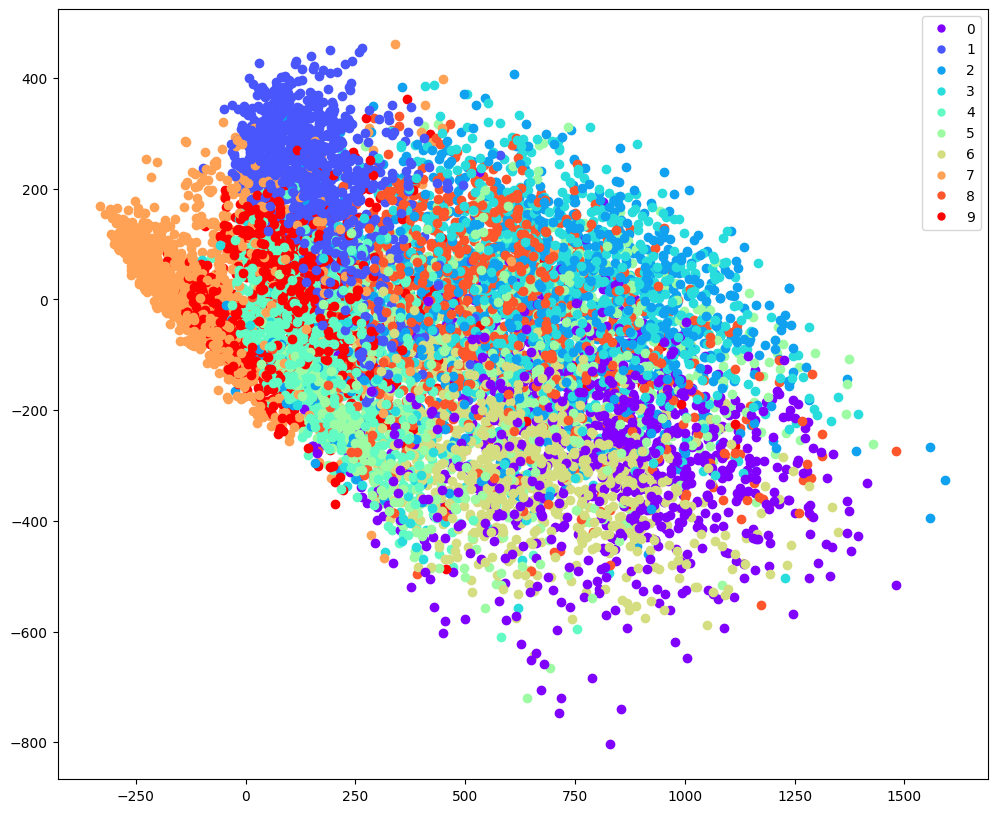

In [78]:
# Plot the projected test data and color by the known label

plt.figure(figsize=(12,10))
for point, label in zip(projectedData, testLabels):
    plt.scatter(point[0], point[1], color=colors[label])

plt.legend(handles=customLegendPoints)
plt.show()

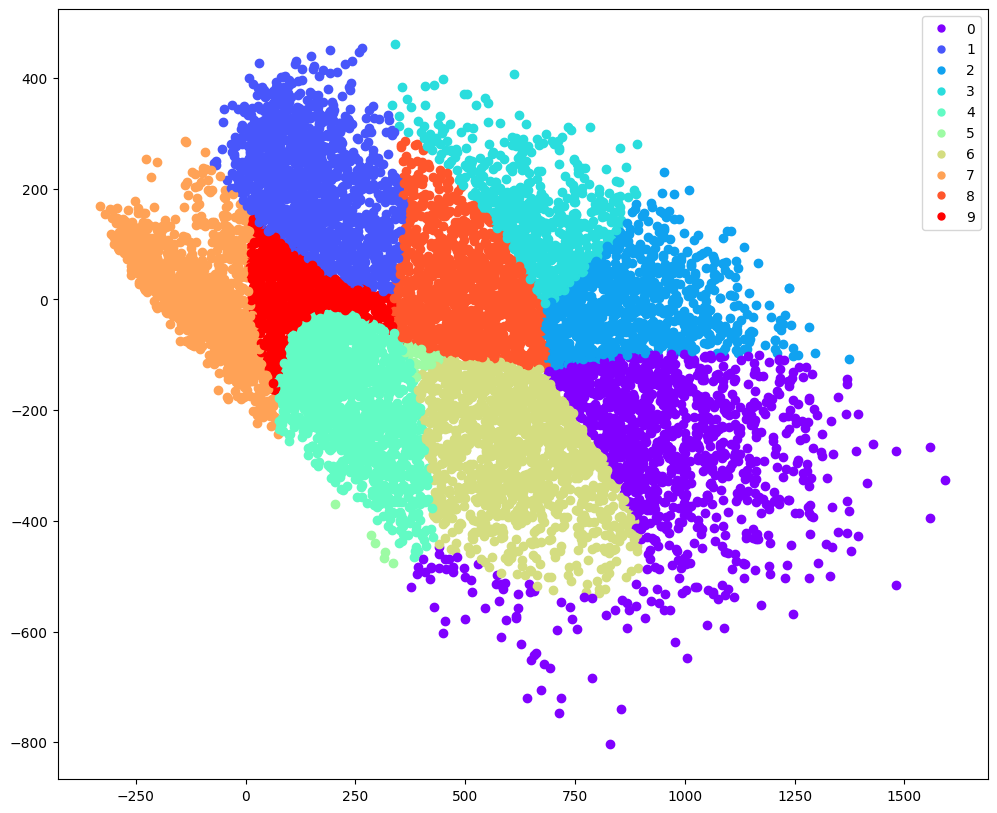

In [79]:
# Plot the projected test data and color by the prediction

plt.figure(figsize=(12,10))
for point,pred in zip(projectedData,predictions):
  plt.scatter(point[0],point[1],color=colors[pred])

plt.legend(handles=customLegendPoints)
plt.show()

In [80]:
# Get predictions for 3d scatter plot
newClassifier.LowerDimensionality(3)
accuracy, predictions, projectedData = newClassifier.score(testData, testLabels)

/tmp/ipykernel_16170/241811137.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussian_likelihoods[i] = res


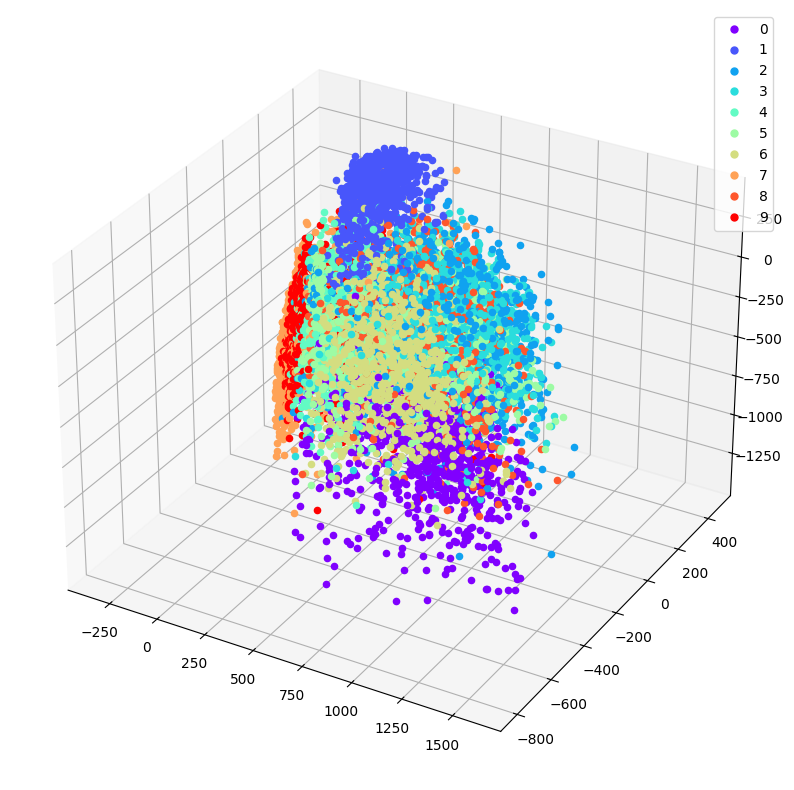

In [81]:
# Plot predicted data in 3 dimensions with known labels

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
for point, label in zip(projectedData.real,testLabels):
  ax.scatter(point[0],point[1], point[2], color = colors[label])

plt.legend(handles=customLegendPoints)
plt.show()

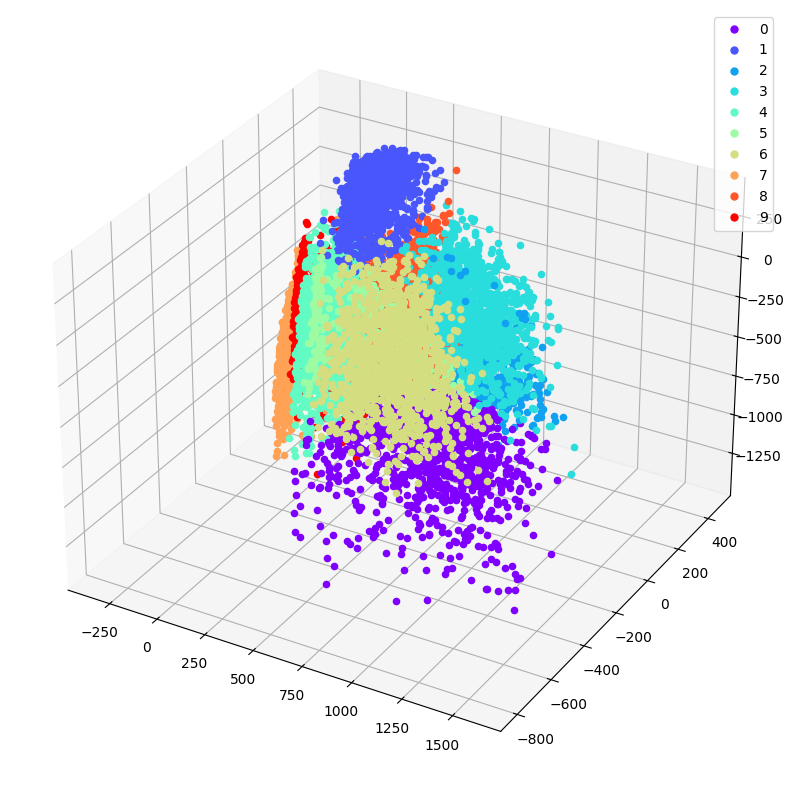

In [82]:
# Plot predicted data in 3 dimensions with predicted labels

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
for point,pred in zip(projectedData.real,predictions):
  ax.scatter(point[0],point[1], point[2], color = colors[pred])

plt.legend(handles=customLegendPoints)
plt.show()